### Loading the data and constructing the graph

* *n* is the numer of nodes used(it is not big since the computations get much slower otherwise)

In [23]:
import pandas as pd
import networkx as nx

n = int(5e4) # number of examples

d_channels = pd.read_csv("/media/tycho/Seagate Expansion Drive/subsets/subset_channels.csv",sep="\t",header=0, nrows=100)
d_comments = pd.read_csv("/media/tycho/Seagate Expansion Drive/subsets/subset_comments.csv",sep="\t",header=0, nrows=n)
d_videos = pd.read_csv("/media/tycho/Seagate Expansion Drive/subsets/subset_videos.csv",sep="\t",header=0, nrows=n)
d_recom = pd.read_csv("/media/tycho/Seagate Expansion Drive/subsets/subset_recommendations.csv",sep="\t",header=0, nrows=n)

G = nx.Graph()

# creating the graph :
for i in range(10):
    G.add_node(d_channels["channel_id"][i],
               attr={"name":"channel","dataset":d_channels["dataset"][i],
                    "title": d_channels['channel_title'][i]})

for i in range(n):
    G.add_node(d_comments["video_id"][i],attr={"name":"video","dataset":d_comments["dataset"][i]})
    G.add_node(d_comments["username"][i],attr = {"name":"user","dataset":d_comments["dataset"][i]})
    G.add_edge(d_recom["video_id"][i],d_recom["target_video_id"][i])
    G.add_node(d_recom["target_video_id"][i],attr = {"name":"target_video"})
    G.add_edge(d_comments["video_id"][i],d_comments["username"][i],attr=d_comments["comment_id"][i])

for i in range(len(d_videos)):
    G.add_node(d_videos["video_id"][i],attr = {"name":"video",
                                               "dataset": d_videos["dataset"][i],
                                               'title': d_videos['video_title'][i]} )    
    G.add_edge(d_videos["video_id"][i],d_videos["channel_id"][i], attr={"name": "vid_ch"})


In [24]:
userNodes_r=[]
userNodes_l=[]
for (p,d) in G.nodes(data=True):
      #print(d["attr"]["name"])
    if d['attr']['name']=="target_video":
          pass
    else:
      if ((d['attr']["name"] == "user") & (d['attr']['dataset'] == 'r')):
         userNodes_r.append(p)
      if ((d['attr']["name"] == "user") & (d['attr']['dataset'] == 'l')):
         userNodes_l.append(p)  


In [6]:
clustering =pd.Series(nx.clustering(G))
clustering = clustering.sort_values(ascending=False)
clustering[:10]

u2QoGtJwZH0    1.0
dbS66qVLMy8    1.0
D47MPYEdzAQ    1.0
WGpcsYr-mOU    1.0
WgQX8a2JP9U    1.0
HBIkj6UdlQg    1.0
Upg-8qjY2KM    1.0
hhKF_jXKwQ0    1.0
1ZXlS8jTldQ    1.0
whJEG1O9cg0    1.0
dtype: float64

### Computing the degree of each node and finding users with largest degree

In [25]:
degrees = list(G.degree())
nodes_ = [n for n,d in degrees]
deg_ = [d for n,d in degrees]
degrees = pd.Series(deg_,index=nodes_)
userDeg_r =degrees[userNodes_r].sort_values(ascending=False)
userDeg_l =degrees[userNodes_l].sort_values(ascending=False)

#### Especially active users(on left and right):

In [26]:
userDeg_l[:10]   # the left users

biggydx                32
ecwaufisxtreme         31
dangerouslytalented    22
upabittoolate          18
ArtypNk                18
cne08                  18
John Smith             15
Therrydicule           14
jxsilicon9             13
Dan MCV                13
dtype: int64

In [27]:
userDeg_r[:10] # the right users

bobbytiger         9
Stefan Molyneux    7
Yesica1993         5
Kon Berner         5
J S                5
James              5
Michael            5
sequorroxx         5
Jonathan           4
John Galt          4
dtype: int64

#### We can compute corpus only for the active users and do analysis with it ...

In [28]:
d_comments2=d_comments.set_index("username")

commentsActiveUsers =d_comments2.loc[userDeg_r[:100].index.dropna()]["comment"]
commentsActiveUsers[:15]

username
bobbytiger                 And a lot of white women prefer bbc also.
bobbytiger         And, I also &quot;heard&quot; that he didn&#39...
bobbytiger         Ana.  So I guess that freedom of speech and th...
bobbytiger         To carry Sandra Fucks, (err.....&quot;Flukes&q...
bobbytiger         My Black Republican is blacker than your, (in ...
bobbytiger         Unfortunately, there&#39;s no surprise here.  ...
bobbytiger         The copy had to shoot the dude again, to take ...
bobbytiger         And a Merry Christm . . . . (umm.......Happy H...
bobbytiger                                            Another study?
bobbytiger         At least Gingrich, unlike the past Democrat VP...
bobbytiger         Given the chance, there is no way I would play...
Stefan Molyneux    Your support is essential to Freedomain Radio,...
Stefan Molyneux                                      not an argument
Stefan Molyneux                              meh not an argument kid
Stefan Molyneux          

In [29]:
clustering[userDeg_l[:10]]

jgccg9xurE8    1.0
dB_H6EtggmM    1.0
wjGQ1GRLBZg    1.0
cZ5vHu-_ds8    1.0
cZ5vHu-_ds8    1.0
cZ5vHu-_ds8    1.0
WIgHO8SZJdI    1.0
wIE1kWqQvsk    1.0
QydN6uOLmxU    1.0
QydN6uOLmxU    1.0
dtype: float64

### Computing the measure *betweenness centrality* and finding most important nodes

Here nodes are found only for a subgraph for the 10 most active users on both sides

In [30]:
import operator
betCen=nx.betweenness_centrality_subset(G,list(userDeg_l[:10].index),list(userDeg_l[:10].index))
betCen=sorted(betCen.items(),key=operator.itemgetter(1),reverse=True)

betCen[:5]

[('06_4MUxsJeg', 5.99908424908425),
 ('0AYHG8G3Dzw', 3.945238095238095),
 ('0BQv8I-mUhE', 3.752380952380952),
 ('01oZP4gCtog', 3.4027777777777777),
 ('098w-xz3Oxo', 2.67997557997558)]

* So these are the most important nodes between top 10 users on left and right

In [32]:
i=0
while i < 10:
    print(G.node[betCen[i][0]]['attr'], betCen[i][1])
    i+=1

{'name': 'video', 'dataset': 'l', 'title': 'Parents Demand Pole Dancing Classes For Kids'} 5.99908424908425
{'name': 'video', 'dataset': 'l', 'title': "Ahmadinejad Hugs Chavez's Mother: Outrage!"} 3.945238095238095
{'name': 'video', 'dataset': 'l', 'title': "Cops Shoot Man Outside Carl's Jr"} 3.752380952380952
{'name': 'video', 'dataset': 'l', 'title': 'Trayvon Martin Shooter Still Not Arrested'} 3.4027777777777777
{'name': 'video', 'dataset': 'l', 'title': 'Can Prayer Cure Aids? Taxpayer Funded Study'} 2.67997557997558
{'name': 'video', 'dataset': 'l', 'title': 'Lady Gaga Steals From Madonna?'} 2.2888278388278387
{'name': 'video', 'dataset': 'l', 'title': "Michael Moore: CNN 'Not News' in Sandy Coverage"} 1.9336080586080584
{'name': 'video', 'dataset': 'l', 'title': 'Lance Armstrong Doping - Guilty?'} 1.9006715506715506
{'name': 'video', 'dataset': 'l', 'title': 'Prop 8: Gay Marriage Ban Ruled Unconstitutional In California'} 1.8494810744810746
{'name': 'video', 'dataset': 'l', 'title

### Computing *degree centrality* and finding the most important nodes

In [35]:
degCen=nx.degree_centrality(G)
degCen=sorted(degCen.items(), key = operator.itemgetter(1),reverse=True)

degCen[:15]

[('UC1yBKRuGpC1tSM73A0ZjYjQ', 0.18040702818859813),
 ('UCvixJtaXuNdMPUGdOPcY8Ag', 0.0751106054860321),
 ('03Is6MT-Hqc', 0.051333586145872835),
 ('UCWq53_f3zgMcWuE-XFKSpyQ', 0.0428517254455821),
 ('UCC3L8QaxqEGUiBC252GHy3w', 0.037037037037037035),
 ('UCaeO5vkdj5xOQHp4UmIN6dw', 0.03515358361774744),
 ('UCrmm_7RDZJeQzq2-wvmjueg', 0.029275692074326884),
 ('01oZP4gCtog', 0.026734926052332193),
 ('04j1RqInHjE', 0.022019972190620653),
 ('03Oqi5TnL8s', 0.017658955884211857),
 ('UCOBNx5Pdw7FZkh2oQR3i9SQ', 0.015914549361648336),
 ('04cBQqHdPmM', 0.013929970926557957),
 ('0BQv8I-mUhE', 0.01328529895082796),
 ('UCldfgbzNILYZA4dmDt4Cd6A', 0.013032486411326),
 ('0C8l9Ln8kuU', 0.012514220705346985)]

* So these are the most central nodes in the graph according to degree centrality

In [39]:
i=0
while i < 15:
    print(G.node[degCen[i][0]]['attr'], degCen[i][1])
    i+=1

{'name': 'channel', 'dataset': 'l', 'title': 'The Young Turks'} 0.18040702818859813
{'name': 'channel', 'dataset': 'l', 'title': 'David Pakman Show'} 0.0751106054860321
{'name': 'video', 'dataset': 'r', 'title': 'A Critical Message From Stefan Molyneux'} 0.051333586145872835
{'name': 'channel', 'dataset': 'r', 'title': 'PJ Media'} 0.0428517254455821
{'name': 'channel', 'dataset': 'r', 'title': 'Stefan Molyneux'} 0.037037037037037035
{'name': 'channel', 'dataset': 'r', 'title': 'The Daily Wire'} 0.03515358361774744
{'name': 'channel', 'dataset': 'l', 'title': 'TheRealNews'} 0.029275692074326884
{'name': 'video', 'dataset': 'l', 'title': 'Trayvon Martin Shooter Still Not Arrested'} 0.026734926052332193
{'name': 'video', 'dataset': 'r', 'title': 'Generation Porn? The Real Reasons Why Men Are Shunning Marriage'} 0.022019972190620653
{'name': 'video', 'dataset': 'r', 'title': 'Ben Shapiro on Louder With Crowder | The Cenk Uygur Debate and Politicon 2017'} 0.017658955884211857
{'name': 'chan

## Finding shortest paths between nodes connected with right nd left

The following computes shortest paths between most active users on left and right

* The problem is that the connection is through the target video from recommendations, which may not be a good connection. 

* Also the label for the target videos is not clear to me, hence no lebel here. But it is apparent that the left media receives some recommendations belonging to the right. Interesting ...

In [40]:
shortestPaths = list(nx.all_shortest_paths(G,userDeg_l.index[1],userDeg_r.index[1]))
for j in range(len(shortestPaths)):
  for i in shortestPaths[j]:
     print(i,G.node[i]['attr'])
  print("\n")

ecwaufisxtreme {'name': 'user', 'dataset': 'l'}
00iHSPuquKg {'name': 'video', 'dataset': 'l', 'title': 'Presidential Coins Going Away?'}
Thezuule {'name': 'user', 'dataset': 'l'}
03Is6MT-Hqc {'name': 'video', 'dataset': 'r', 'title': 'A Critical Message From Stefan Molyneux'}
Stefan Molyneux {'name': 'user', 'dataset': 'r'}


ecwaufisxtreme {'name': 'user', 'dataset': 'l'}
06_4MUxsJeg {'name': 'video', 'dataset': 'l', 'title': 'Parents Demand Pole Dancing Classes For Kids'}
Thezuule {'name': 'user', 'dataset': 'l'}
03Is6MT-Hqc {'name': 'video', 'dataset': 'r', 'title': 'A Critical Message From Stefan Molyneux'}
Stefan Molyneux {'name': 'user', 'dataset': 'r'}


ecwaufisxtreme {'name': 'user', 'dataset': 'l'}
00iHSPuquKg {'name': 'video', 'dataset': 'l', 'title': 'Presidential Coins Going Away?'}
zoidberg444 {'name': 'user', 'dataset': 'l'}
03Is6MT-Hqc {'name': 'video', 'dataset': 'r', 'title': 'A Critical Message From Stefan Molyneux'}
Stefan Molyneux {'name': 'user', 'dataset': 'r'}



### The following computes shortest paths between chanels on the left and right

* So there are users that comment both on the left and right videos/channels

In [41]:
shortestPaths = list(nx.all_shortest_paths(G,d_channels['channel_id'][1],d_channels['channel_id'][8]))
for j in range(len(shortestPaths)):
  for i in shortestPaths[j]:
     print(i,G.node[i]['attr'])
  print("\n")

UCldfgbzNILYZA4dmDt4Cd6A {'name': 'channel', 'dataset': 'l', 'title': 'Secular Talk'}
0A7-UC78GUE {'name': 'video', 'dataset': 'l', 'title': 'Idaho Tries To Censor Sexual TV'}
devourerofbabies {'name': 'user', 'dataset': 'l'}
03unoBg06G0 {'name': 'video', 'dataset': 'l', 'title': "Slavery 'A Blessing In Disguise' - Republican Representative"}
eggory {'name': 'user', 'dataset': 'r'}
0C8l9Ln8kuU {'name': 'video', 'dataset': 'r', 'title': "I Got a Channel Strike, Now I can't Livestream"}
UCG749Dj4V2fKa143f8sE60Q {'name': 'channel', 'dataset': 'r', 'title': 'Tim Pool'}


UCldfgbzNILYZA4dmDt4Cd6A {'name': 'channel', 'dataset': 'l', 'title': 'Secular Talk'}
0A7-UC78GUE {'name': 'video', 'dataset': 'l', 'title': 'Idaho Tries To Censor Sexual TV'}
devourerofbabies {'name': 'user', 'dataset': 'l'}
03unoBg06G0 {'name': 'video', 'dataset': 'l', 'title': "Slavery 'A Blessing In Disguise' - Republican Representative"}
iudfr {'name': 'user', 'dataset': 'r'}
0C8l9Ln8kuU {'name': 'video', 'dataset': '

In [ ]:
#nx.center(G)

## A test graph for plotting

Only for a small number, here 200 nodes ..

In [22]:
G_test = nx.Graph()
n=200

for i in range(10):
    G_test.add_node(d_channels["channel_id"][i],attr={"name":"channel"})

for i in range(n):
    G_test.add_node(d_videos["video_id"][i],attr = {"name":"video"})    
    G_test.add_edge(d_videos["video_id"][i],d_videos["channel_id"][i], attr={"name": "vid_ch"})

for i in range(n):
    G_test.add_node(d_comments["video_id"][i],attr={"name":"video"})
    G_test.add_node(d_comments["username"][i],attr = {"name":"user"})
    G_test.add_edge(d_recom["video_id"][i],d_recom["target_video_id"][i])
    G_test.add_node(d_recom["target_video_id"][i],attr = {"name":"target_video"})
    G_test.add_edge(d_comments["video_id"][i],d_comments["username"][i],attr=d_comments["comment_id"][i])

In [23]:
list(G.edges(data=True))[:10]

[('UC1yBKRuGpC1tSM73A0ZjYjQ', '001F4tq6Cng', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '-00hKoxX_vk', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '00iHSPuquKg', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '00I-Tor-AVM', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '00lovy-JkDw', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '00q6BKYR1U8', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '01EMJH41Xx4', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '01mKJU7G6hU', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '01o5LBd2c6k', {'attr': {'name': 'vid_ch'}}),
 ('UC1yBKRuGpC1tSM73A0ZjYjQ', '01oZP4gCtog', {'attr': {'name': 'vid_ch'}})]

In [25]:
list(G.nodes(data=True))[:15]

[('UC1yBKRuGpC1tSM73A0ZjYjQ', {'attr': {'name': 'channel', 'dataset': 'l'}}),
 ('UCldfgbzNILYZA4dmDt4Cd6A', {'attr': {'name': 'channel', 'dataset': 'l'}}),
 ('UCvixJtaXuNdMPUGdOPcY8Ag', {'attr': {'name': 'channel', 'dataset': 'l'}}),
 ('UC-3jIAlnQmbbVMV6gR7K8aQ', {'attr': {'name': 'channel', 'dataset': 'l'}}),
 ('UCrmm_7RDZJeQzq2-wvmjueg', {'attr': {'name': 'channel', 'dataset': 'l'}}),
 ('UCWq53_f3zgMcWuE-XFKSpyQ', {'attr': {'name': 'channel', 'dataset': 'r'}}),
 ('UCC3L8QaxqEGUiBC252GHy3w', {'attr': {'name': 'channel', 'dataset': 'r'}}),
 ('UCaeO5vkdj5xOQHp4UmIN6dw', {'attr': {'name': 'channel', 'dataset': 'r'}}),
 ('UCG749Dj4V2fKa143f8sE60Q', {'attr': {'name': 'channel', 'dataset': 'r'}}),
 ('UCOBNx5Pdw7FZkh2oQR3i9SQ', {'attr': {'name': 'channel', 'dataset': 'r'}}),
 ('001F4tq6Cng', {'attr': {'name': 'video', 'dataset': 'l'}}),
 ('00ARaR_Y_II', {'attr': {'name': 'video', 'dataset': 'l'}}),
 ('-00hKoxX_vk', {'attr': {'name': 'video', 'dataset': 'l'}}),
 ('00I47iBo-fQ', {'attr': {'nam

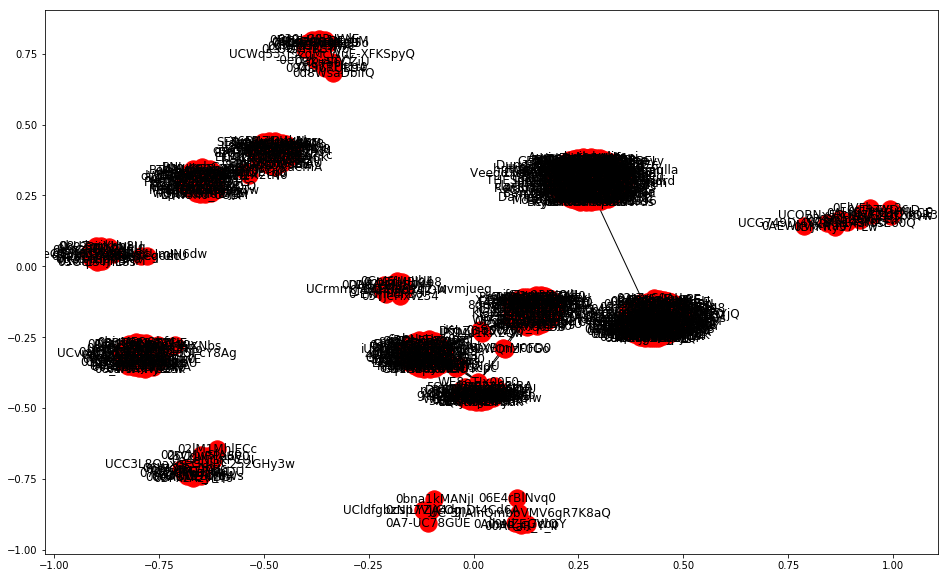

In [19]:
%matplotlib inline

plt.figure(figsize=(16,10))
nx.draw_networkx(G_test)

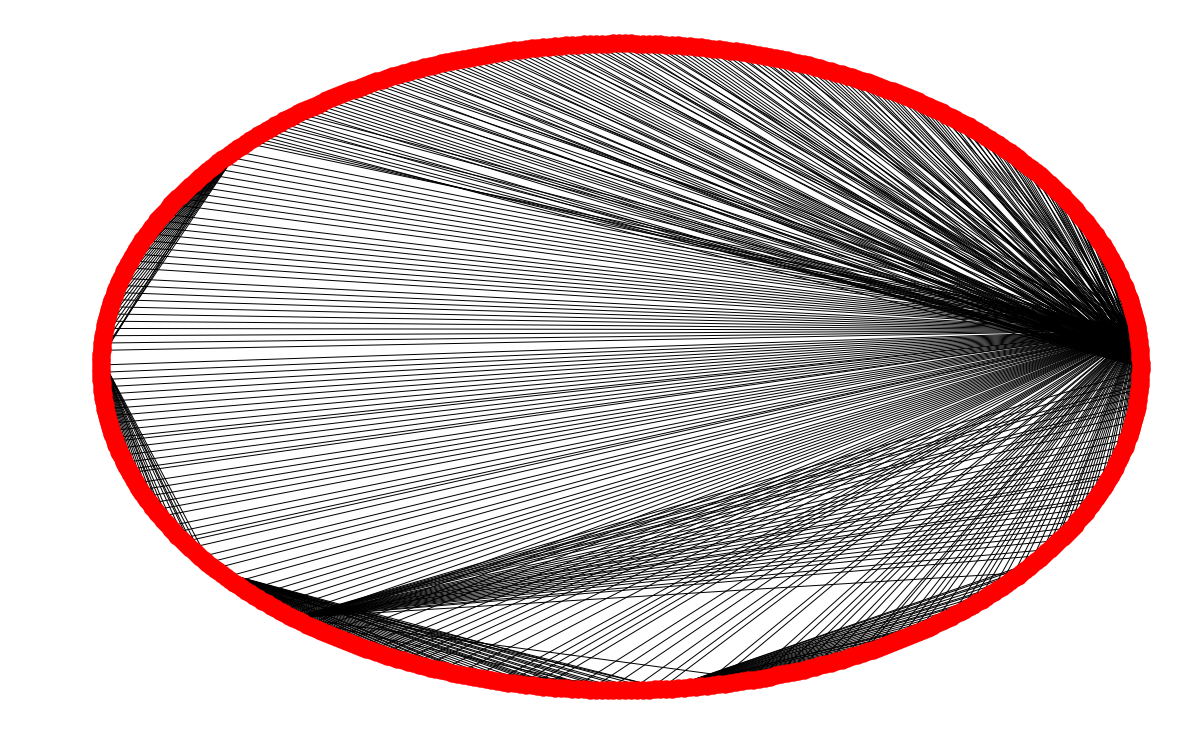

In [20]:
plt.figure(figsize=(16,10))
nx.draw_circular(G_test)

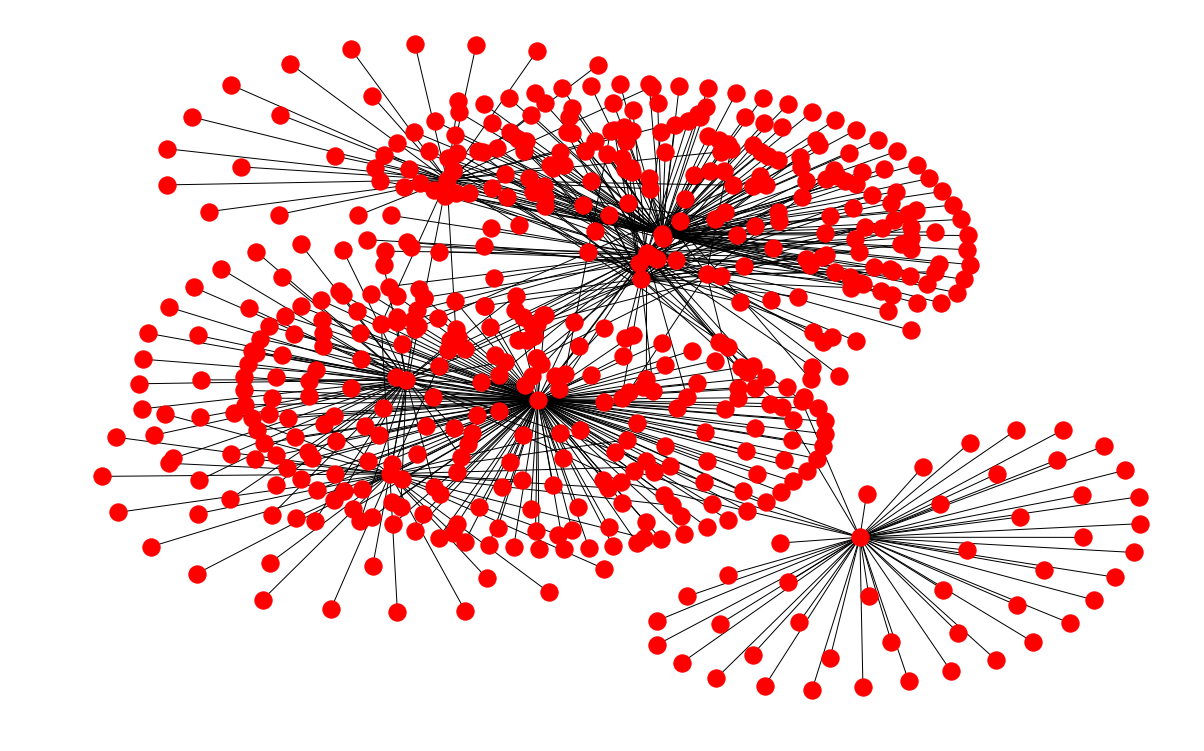

In [21]:
plt.figure(figsize=(16,10))
nx.draw_kamada_kawai(G_test)